# Analysis of two real datasets with ScanOFC

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from scanfc.clustering import FoldChanges, Clustering
from clustering_suppl_functions import (scale_data, reorder_clusters)
import warnings
warnings.filterwarnings('ignore')
for style in plt.style.available:
    if 'seaborn' in style:
        mpl.style.use(style)
        break
mpl.rcParams['font.family'] = 'serif' 

## Step 1: Data extraction

In [2]:
### Data extraction: LINAC
trans_data_linac = pd.read_excel('Data/Table_LINAC.xlsx')
trans_data_linac = trans_data_linac.where(trans_data_linac.loc[:,'Dose(Gy)']!=2)
trans_data_linac = trans_data_linac.dropna(axis=0, how='all').dropna(axis=1, how='any')
gene_names_linac = trans_data_linac.columns[5:]
nb_var_linac = len(gene_names_linac)
trans_measures_linac = trans_data_linac.values[:, 5:]
time_pts = trans_data_linac.values[:15:3, 3].astype(float)
timelen = len(time_pts)
dim_data = trans_measures_linac.shape
# Reshaping to fit the required format:
linac_data_reshaped = np.reshape(trans_measures_linac, (2, 3*timelen, dim_data[1]))
linac_data_reshaped = np.reshape(linac_data_reshaped, (2, timelen, 3, dim_data[1]))
linac_log2_data = np.log2(linac_data_reshaped.transpose((1,0,2,3)).astype(float))

## Step 2: Fold Changes Estimation & Scaling

In [3]:
### Defining unsclaled fold changes:
fc_basic_linac = FoldChanges(data=linac_log2_data, var_names=gene_names_linac, time_points=time_pts)
fc_means_linac = fc_basic_linac.means
fc_sd_linac = np.sqrt(np.diagonal(fc_basic_linac.cov, axis1=1, axis2=2))
### Defining sclaled fold changes:
linac_log2_data_doublenorm = scale_data(linac_log2_data, fc_basic_linac)
fc_doublenorm_linac = FoldChanges(data=linac_log2_data_doublenorm, var_names=gene_names_linac, time_points=time_pts)

## Step 3: Fold Changes Clustering & Alignment

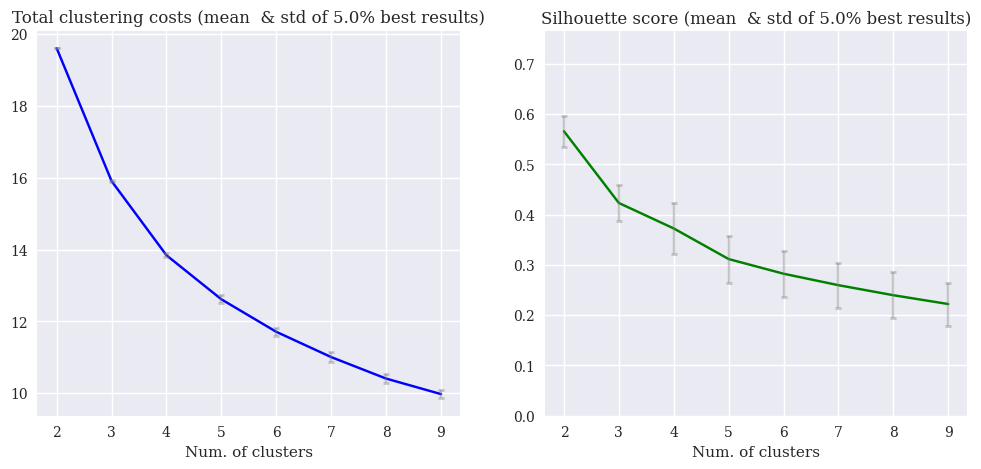

In [4]:
### Clustering & Alignment of LINAC data:
random_gen=np.random.RandomState(1)
max_warp_step = 1
pen_param_linac = 0.075
cl_linac = Clustering(fold_changes=fc_doublenorm_linac, dist='d2hat', time_warp=True, 
                      max_warp_step=max_warp_step, sign_pen=True,
                      pen_param=pen_param_linac, random_gen=random_gen)

### Clustering with d2hat k-medoids:
(k_clusters_linac,
 k_centroids_linac,
 k_warps_linac,
 k_costs_linac) = cl_linac.fc_clustering(range(2, 10), nb_rep=2000, nb_best=100, disp_plot=True, silhouette=True)

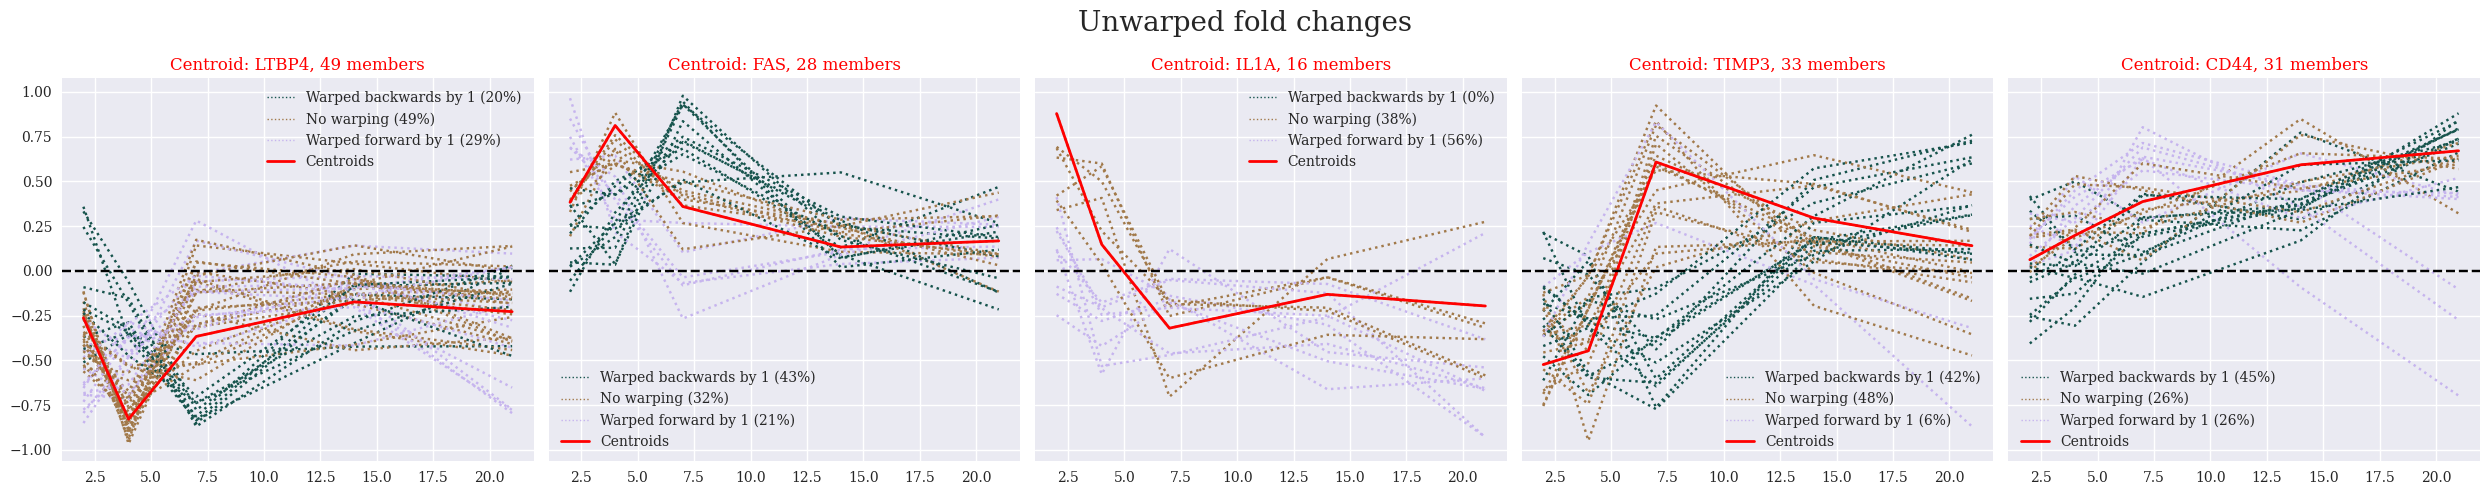

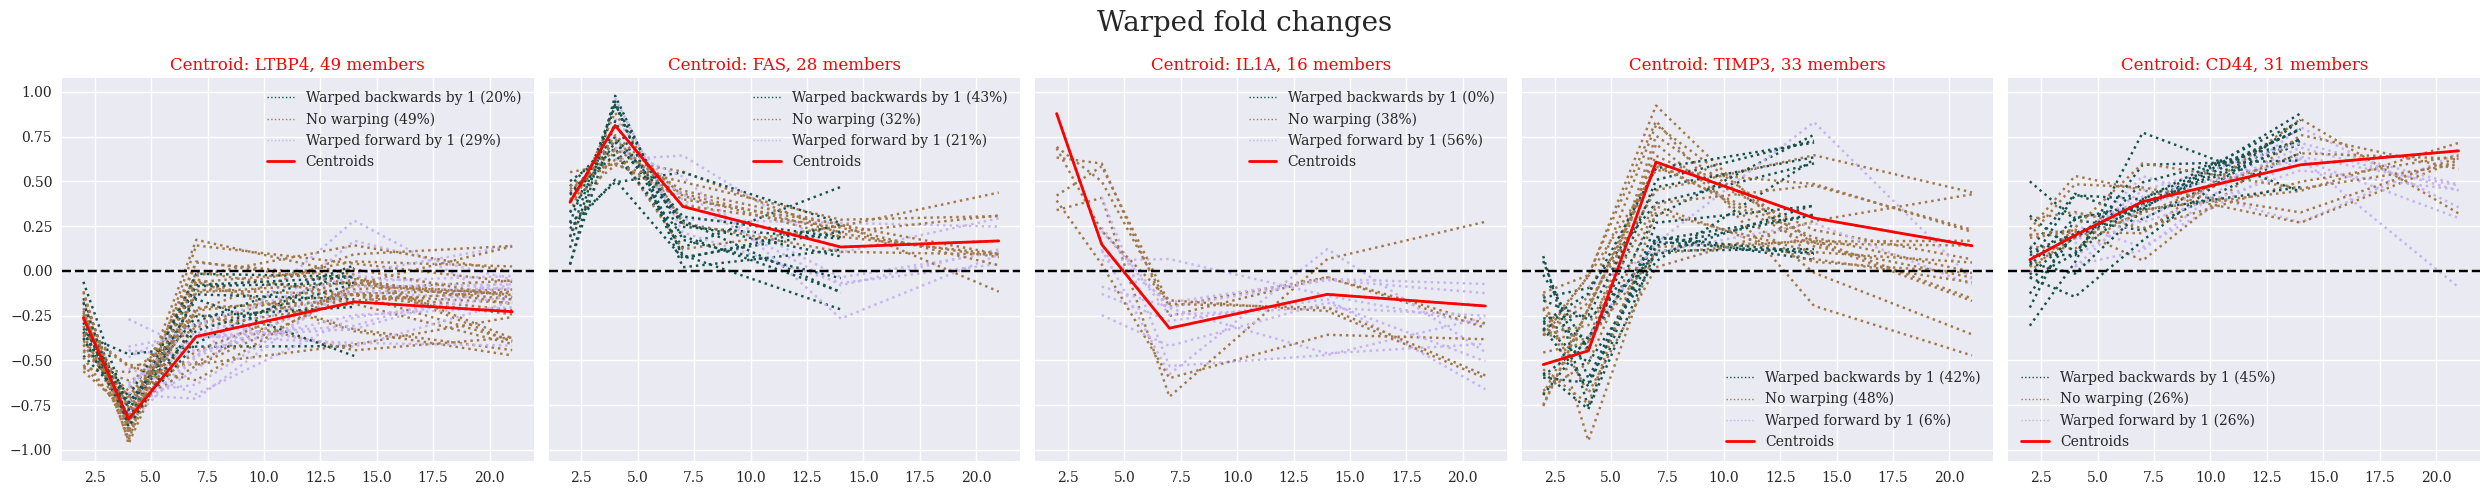

In [5]:
### 5 clusters:
nb_cl = 5
cl_linac.plot_clusters(nb_cl, k_clusters_linac, k_centroids_linac, 
                       warps=k_warps_linac, nb_cols=nb_cl, nb_rows=1, figsize=(5 * nb_cl, 5))

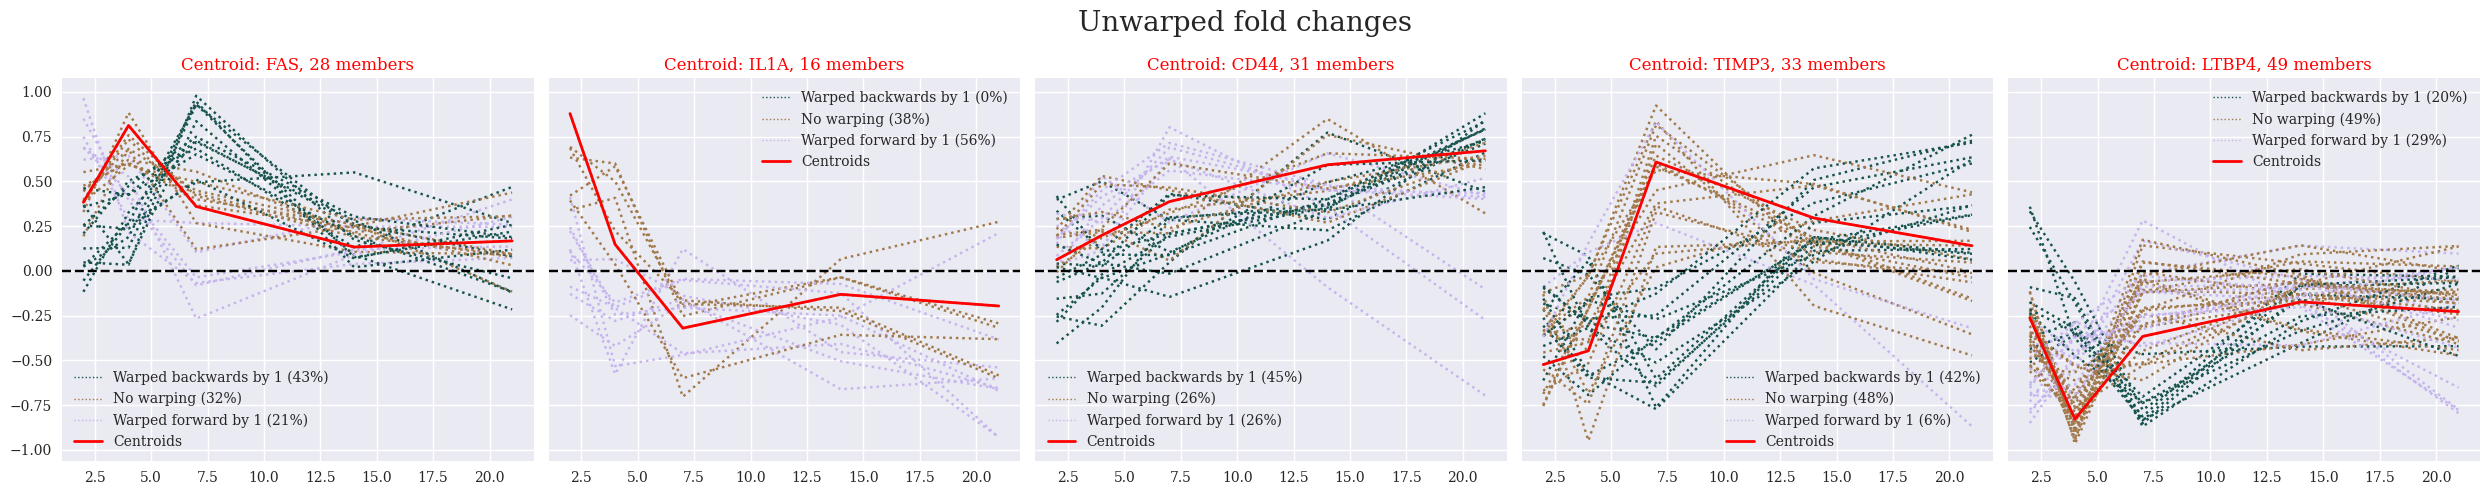

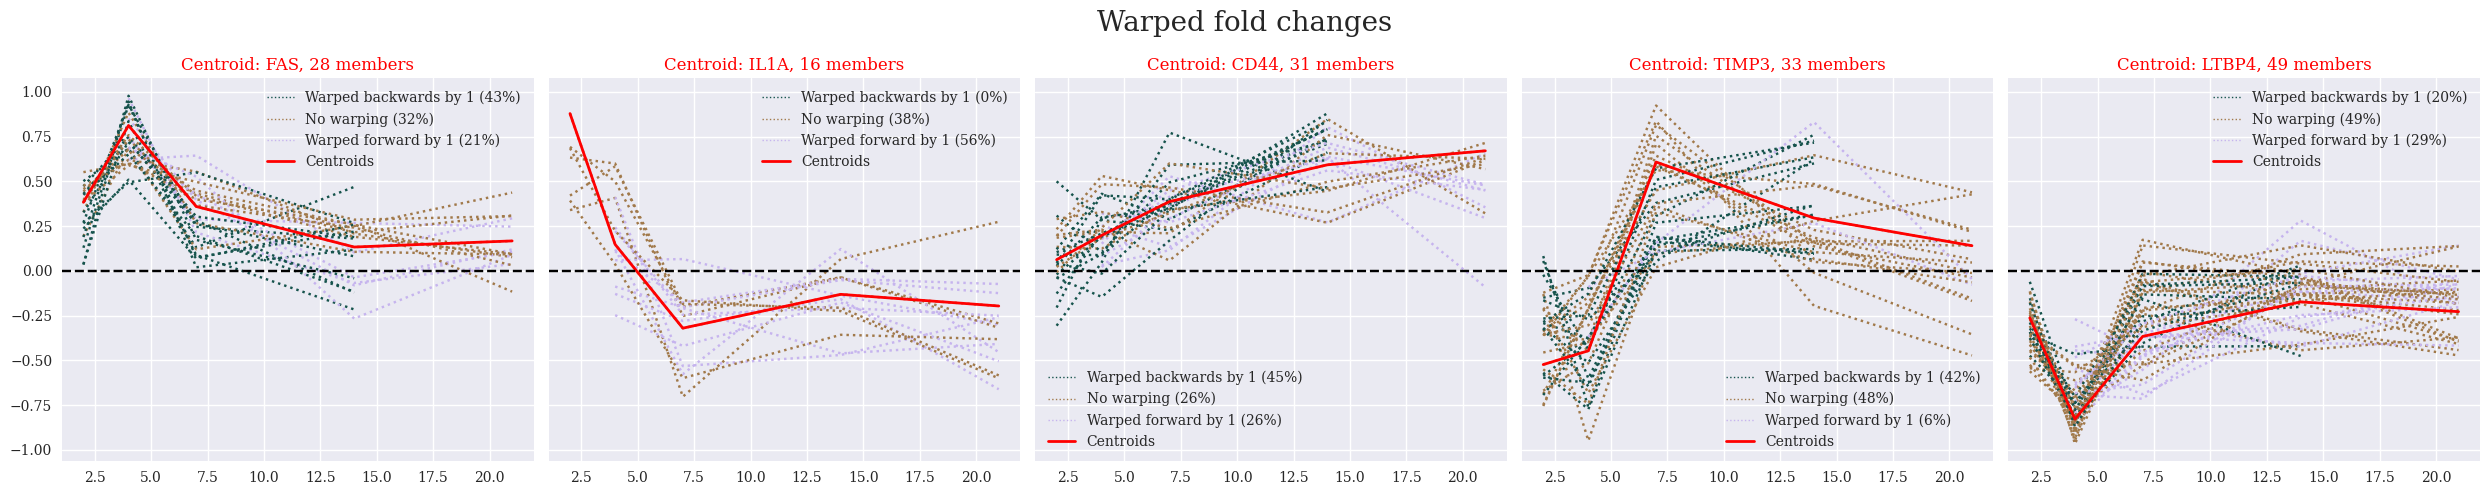

In [6]:
# Reorder clusters for convenience:
(fc_clusters_linac_no,
 fc_centroids_linac_no) = reorder_clusters((1,2,4,3,0), k_clusters_linac[str(nb_cl)], k_centroids_linac[str(nb_cl)])
cl_linac.plot_clusters(nb_cl, fc_clusters_linac_no, fc_centroids_linac_no, 
                       warps=k_warps_linac[str(nb_cl)], nb_cols=nb_cl, nb_rows=1, figsize=(5 * nb_cl, 5))

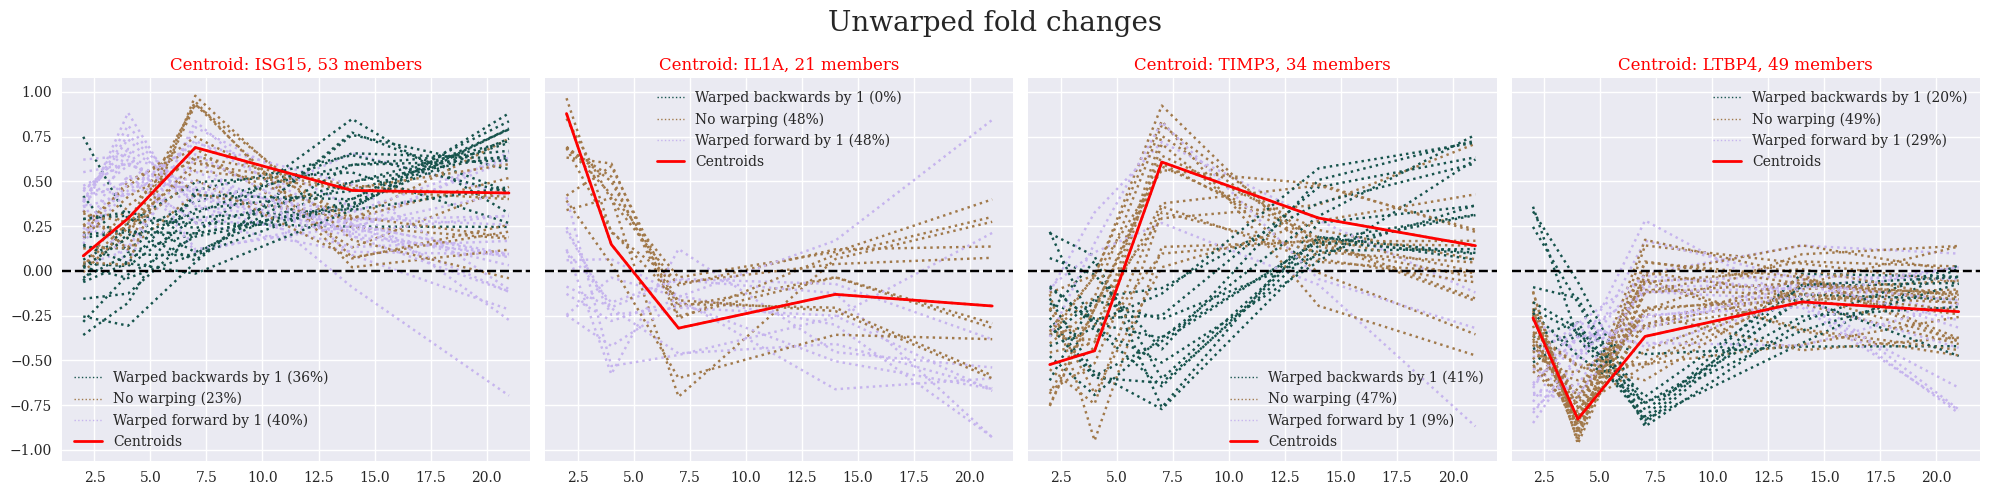

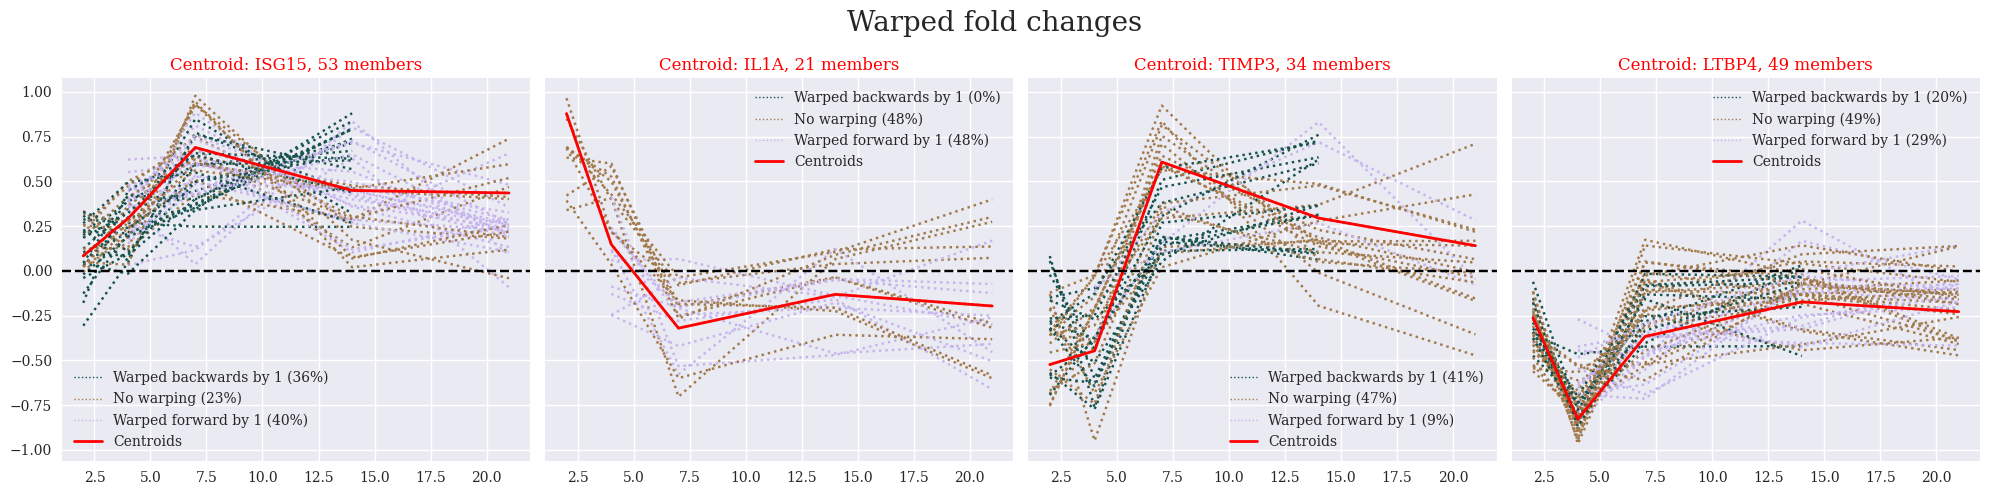

In [7]:
# 4 clusters:
nb_cl = 4
# Reorder clusters for convenience:
(fc_clusters_linac_no_4,
 fc_centroids_linac_no_4) = reorder_clusters((1,2,3,0), k_clusters_linac[str(nb_cl)], k_centroids_linac[str(nb_cl)])
cl_linac.plot_clusters(nb_cl, fc_clusters_linac_no_4, fc_centroids_linac_no_4, 
                       warps=k_warps_linac[str(nb_cl)], nb_cols=nb_cl, nb_rows=1, figsize=(5 * nb_cl, 5))

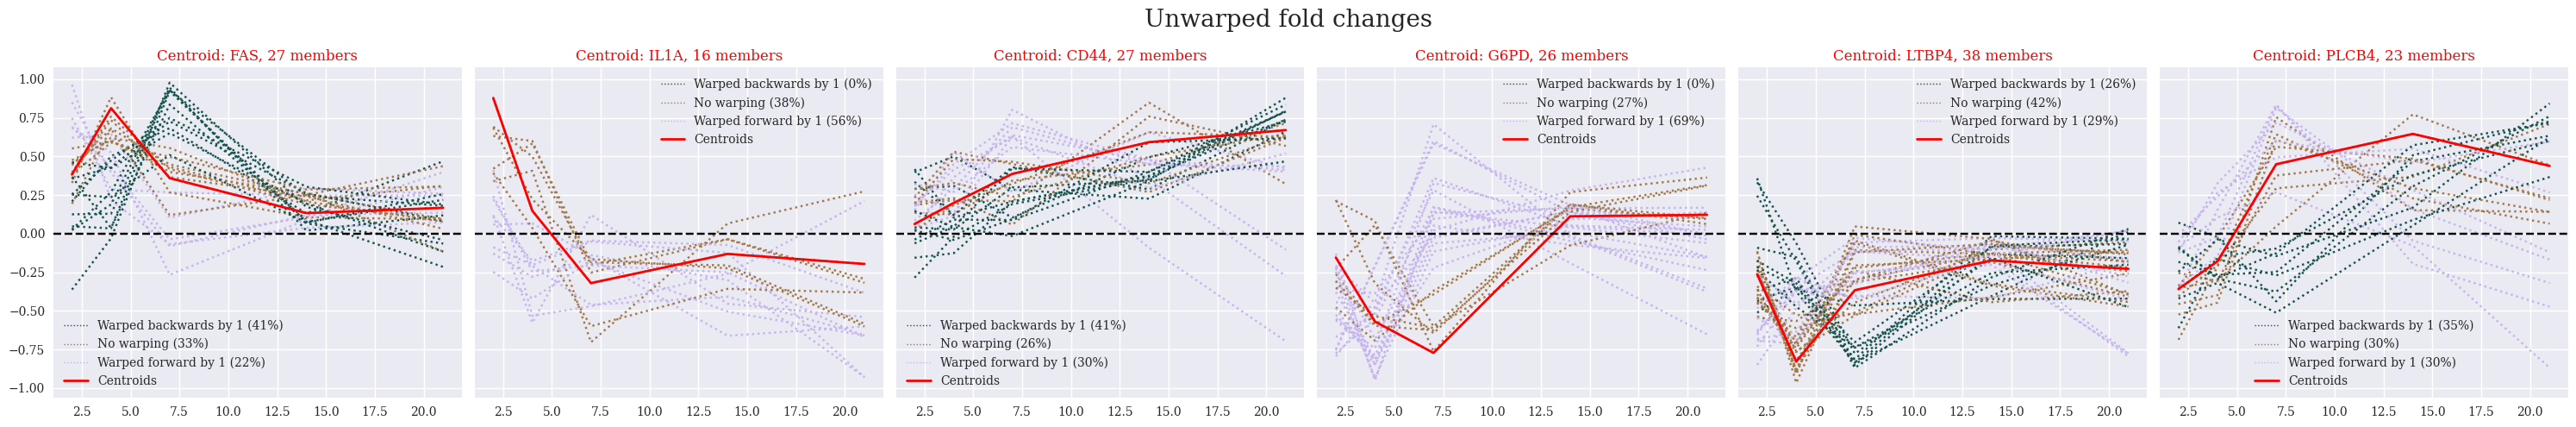

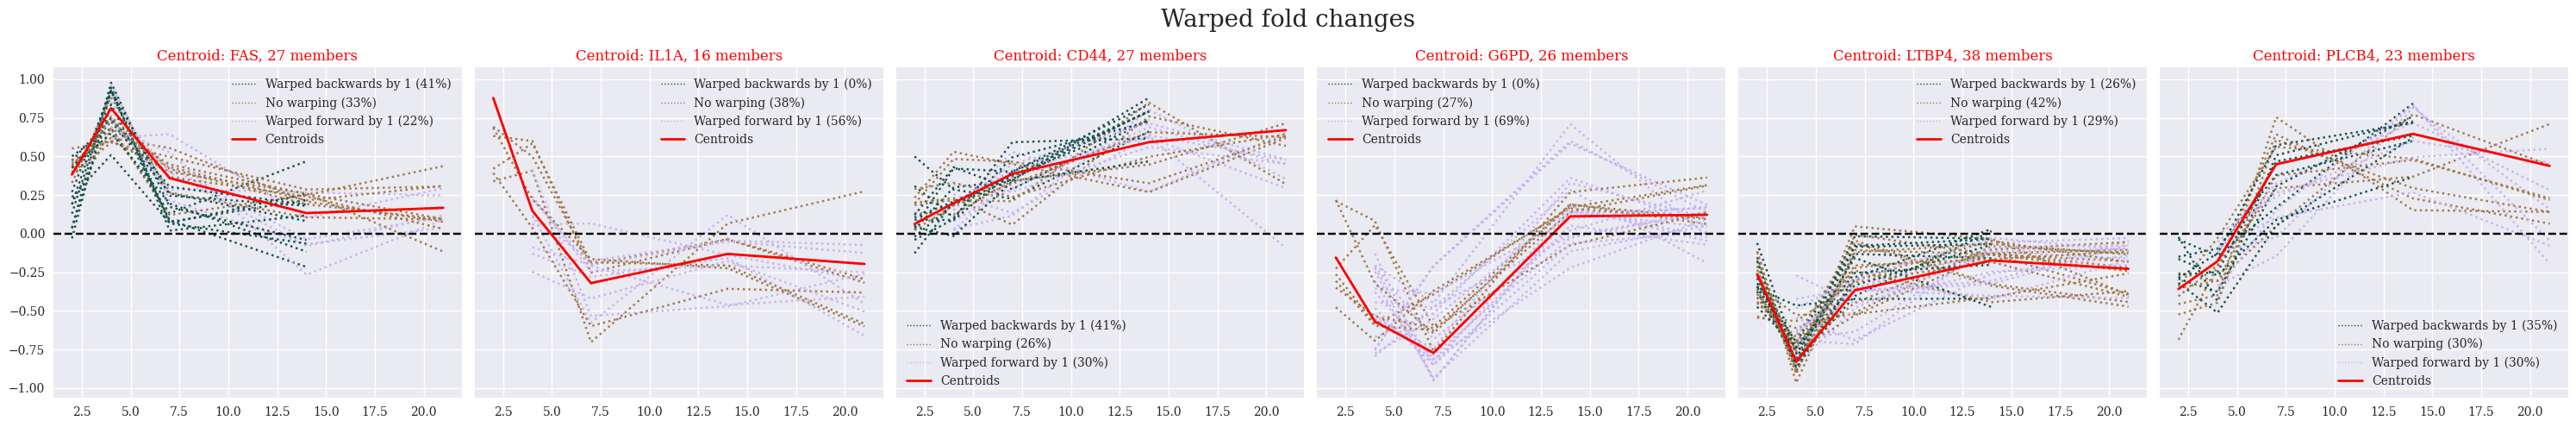

In [8]:
# 6 clusters:
nb_cl = 6
# Reorder clusters for convenience:
(fc_clusters_linac_no_6,
 fc_centroids_linac_no_6) = reorder_clusters((3,5,4,1,0,2), k_clusters_linac[str(nb_cl)], k_centroids_linac[str(nb_cl)])
cl_linac.plot_clusters(nb_cl, fc_clusters_linac_no_6, fc_centroids_linac_no_6, 
                       warps=k_warps_linac[str(nb_cl)], nb_cols=nb_cl, nb_rows=1, figsize=(5 * nb_cl, 5))

In [9]:
### OWD-based Spectral Clustering:
# Transforming OWD into a similarity matrix
sim_mat_linac = ((-cl_linac.dist_mat + cl_linac.dist_mat.max()) / 
                    cl_linac.dist_mat.max())
nb_cl = 5
sp = SpectralClustering(n_clusters=nb_cl, random_state=0, 
                        assign_labels='cluster_qr', n_init=2000,
                        affinity='precomputed').fit(sim_mat_linac)

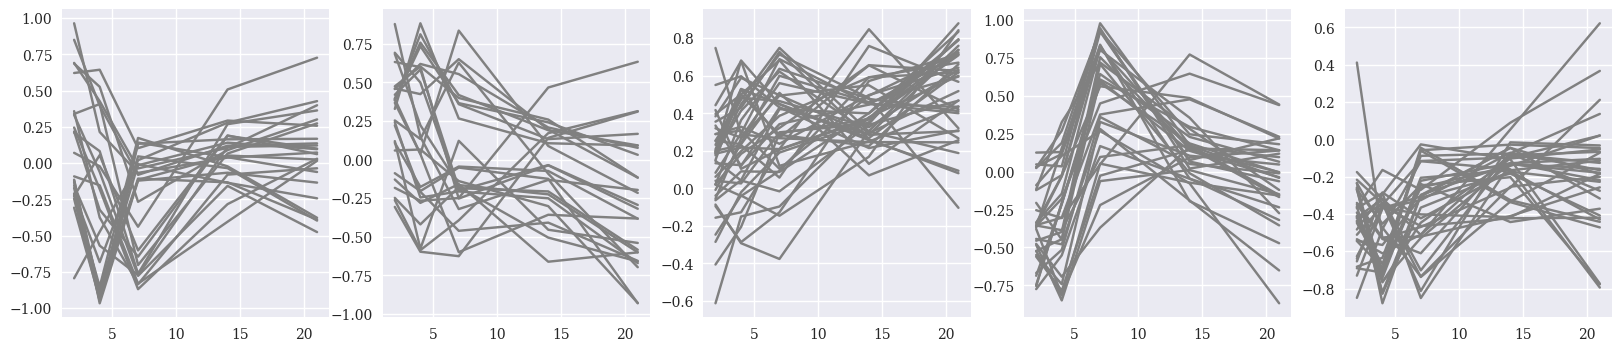

In [10]:
sp_new_order = (0, 1, 3, 2, 4)
fc_pred_sp_no = reorder_clusters(sp_new_order, sp.labels_, np.arange(nb_cl))[0]

fig, axs = plt.subplots(1, nb_cl, figsize=(20, 4))
for i in range(nb_cl):
    axs[i].plot(time_pts, fc_doublenorm_linac.means[:, (fc_pred_sp_no==i).nonzero()[0]], 
                color='grey')
plt.show()

In [11]:
print(contingency_matrix(fc_clusters_linac_no, fc_pred_sp_no))

[[ 5  8 10  5  0]
 [ 1 14  0  0  1]
 [ 0  1 28  2  0]
 [ 7  3  3 18  2]
 [12  0  0  6 31]]


In [12]:
### Silhouette Score test:
silhouette_score_kmed = silhouette_score(cl_linac.dist_mat, k_clusters_linac[str(nb_cl)], 
                                         metric="precomputed")
print("Silhouette score, OWD-based k-medoids: ", silhouette_score_kmed)
silhouette_score_sp = silhouette_score(cl_linac.dist_mat, fc_pred_sp_no, 
                                         metric="precomputed")
print("Silhouette score, OWD-based spectral clustering: ", silhouette_score_sp)

Silhouette score, OWD-based k-medoids:  0.31364926483931416
Silhouette score, OWD-based spectral clustering:  0.19024845226175982
